## Access the MODIS web service and perform quality filtering using R

*Author: Jack McNelis*  
*Date: March 27, 2018*  
*Contact for the ORNL DAAC: uso@daac.ornl.gov*

### Keywords: MODIS, web service, R, SOAP

## Overview
This notebook will explore using the **MODISTools** library in <b>R</b> to access MODIS Land Products through a standards based SOAP (Simple Object Access Protocol) Web Service hosted by the ORNL DAAC.

Using the MODIS Web Service users can:

* Retrieve MODIS subsets through command line operations
* Download and integrate subsets directly into client-side workflows
* Download and visualize subsets with customized code 
* ... and much more.

This tutorial will demonstrate how to do the following in R:

* build a time series of MOD11A2 land surface temperature from multiple web service requests
* format subset responses for easy integration in R workflows
* perform quality control filtering based on MODIS qc criteria

## Prerequisites: 

R Libraries: MODISTools, ggplot2, scales, tidyr

### MODISTools

MODISTools is an R library that provides functions for retrieving subsets of MODIS data using the ORNL DAAC [MODIS Web Service](https://modis.ornl.gov/data/modis_webservice.html) and processing them to a format ready for user-friendly application in R. 

Tuck, S.L., Phillips, H.R.P., Hintzen, R.E., Scharlemann, J.P.W., Purvis, A. and Hudson, L.N. (2014) MODISTools -- downloading and processing MODIS remotely sensed data in R. Ecology and Evolution, 4 (24), 4658--4668. [10.1002/ece3.1273](https://onlinelibrary.wiley.com/doi/abs/10.1002/ece3.1273).

## Tutorial

### Install MODISTools R package

The latest version of the MODISTools library is not available through CRAN. The ORNL DAAC hopes to make it available through CRAN in the near future.

For now, it must be installed manually. The latest version is available through this repository:  
[Download MODISTools.tar.gz](MODISTools.tar)

Download the archive to your local machine and install using the following command:

In [ ]:
install.packages("MODISTools.tar.gz",repos=NULL,type="source") # Be sure to specify the path to the archive

### Import MODISTools and other libraries

In [1]:
library(MODISTools)
library(ggplot2)
library(scales)
library(tidyr)

### Explore available web service functions

MODIS Web Service functions are described at the web page below:  
https://modis.ornl.gov/data/modis_webservice.html

#### GetProducts()

See what MODIS products are available via the web service using the **GetProducts()** function:

In [2]:
GetProducts()

[1] "MCD12Q1"  "MCD12Q2"  "MCD15A2H" "MCD15A3H" "MOD09A1"  "MOD11A2" 
 [7] "MOD13Q1"  "MOD15A2H" "MOD17A2H" "MOD17A3H" "MYD09A1"  "MYD11A2" 
[13] "MYD13Q1"  "MYD15A2H" "MYD17A2H" "MYD17A3H"

####  GetBands("product")
* product --- string; MODIS product code as listed by **GetProducts()**

See what bands are available for the [MOD11A2 Land Surface Temperature/Emissivity](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod11a2_v006) product using the **GetBands()** function:

In [3]:
GetBands('MOD11A2')

[1] "Clear_sky_days"   "Clear_sky_nights" "Day_view_angl"    "Day_view_time"   
 [5] "Emis_31"          "Emis_32"          "Night_view_angl"  "Night_view_time" 
 [9] "QC_Day"           "QC_Night"         "LST_Day_1km"      "LST_Night_1km"

#### GetDates(latitude, longitude, "product")
The MODIS Web Service has a ten tile limit per request to ensure responsivity of the service and to avoid time outs. The **GetDates()** function is used to create a list of available dates for the specified coordinate and MODIS product.

| Parameter          | Type    | Description                                                   |
|:-------------------|:-------:|:--------------------------------------------------------------|
| **lat**            | float   | latitude                                                      |
| **long**           | float   | longitude                                                     |
| **product**        | string  | MODIS product code as listed by **GetProducts()**             |

Create a list of dates for MOD11A2 for a coordinate in North Table Mountain Ecological Reserve in California (39.56499, -121.55527) using the **GetDates()** function:

In [4]:
dates <- GetDates(39.56499, -121.55527, 'MOD11A2')

# Print the first ten MODIS dates
dates[1:10]

[1] "A2000049" "A2000057" "A2000065" "A2000073" "A2000081" "A2000089"
 [7] "A2000097" "A2000105" "A2000113" "A2000121"

#### **GetSubset(lat, long, "product", "band", "start_date", "end_date", km_above/below, km_left/right)**          
Returns the subset specified by the input parameters. km_above/below and km_left/right indicates the number of kilometers above and below, left and right of the center pixel of the subset; e.g. for a 500-m product (MOD09A1) 10, 10 will result in a subset with a spatial extent covering 20.5- x 20.5-km.  

| Parameter          | Type    | Description                                                   |
|:-------------------|:-------:|:--------------------------------------------------------------|
| **lat**            | float   | latitude                                                      |
| **long**           | float   | longitude                                                     |
| **product**        | string  | MODIS product code as listed by **GetProducts()**             |
| **band**           | string  | band ID as listed by **GetBands()**                           |
| **start_date**     | string  | start date as listed by **GetDates()**                        |
| **end_date**       | string  | end date as listed by **GetDates()**                          |
| **km_above/below** | integer | number of kilometers to subset above and below center pixel   |
| **km_left/right**  | integer | number of kilometers to subset left and right of center pixel |

Submit a request for the MOD11A2 daytime LST 8-day composite for January 1, 2001 for a 4.5- by 4.5-km area in North Table Mountain Ecological Reserve in California (39.56499, -121.55527) using the **GetSubset()** function:

In [5]:
subset <- GetSubset(39.56499, -121.55527, 'MOD11A2', 'LST_Day_1km', 'A2001001', 'A2001001', 2, 2)
subset

xll,yll,pixelsize,nrow,ncol,band,scale,lat,long,subset
-10421756.18,4396837.72,926.62543305583381,5,5,LST_Day_1km,0.02,39.56499,-121.55527,"MOD11A2.A2001001.h08v05.006.2015111234608.LST_Day_1km,MOD11A2,A2001001,Lat39.56499Lon-121.55527Samp5Line5,2015111234608,14341,14349,14366,14391,14404,14360,14354,14363,14351,14344,14328,14299,14270,14374,14396,14285,14294,14293,14375,14364,14353,14301,14271,14350,14270"


The **MODISTools** library formats the SOAP XML response of the **GetSubset()** function as an R data.frame (see <b>Out [5]</b>).  The first nine variables of the data.frame provide general metadata about your subset:  

* *xll* --- MODIS sinusoidal x-coordinate of the lower left corner of the subset
* *yll* --- MODIS sinusoidal y-coordinate of the lower left corner of the subset
* *pixelsize* --- cell size in meters
* *nrow* --- number of rows in the subset
* *ncol* --- number of columns in the subset
* *band* --- requested band
* *scale* --- scale factor
* *lat* --- latitude of center pixel of subset
* *long* --- longitude of center pixel of subset

The *subset* variable contains the subset data as a list of lines in CSV format:

| **Column Number** | **Header**   | **Data**                                                   | **Description**            |
|-------------------|--------------|------------------------------------------------------------|----------------------------|
|         1         | HDFname      | MOD13Q1.A2000049.h10v05.006.2015136104605.250m_16_days_EVI | HDF file for row timestamp |
|         2         | Product      | MOD13Q1                                                    | MODIS Product name         |
|         3         | Date         | A2000049                                                   | MODIS julian date          |
|         4         | Location     | Lat35Lon-90Samp1Line1                                      | Pixel location             |
|         5         |Processed_Date| 2015136104605                                              | Date of HDF processing     |
|         6 - n     | Subset_Data  | 2218                                                       | Requested data value(s)    |

Convert the *subset* variable into a new data.frame using the *separate()* function from the <b>tidyr</b> package:

In [6]:
subset <- separate(as.data.frame(subset$subset), 1, c('HDFname', 'Product', 'Date', 'Location', 'Processed_Date', 'Subset_Data'), sep = ",", remove = TRUE, extra = 'merge')
subset

HDFname,Product,Date,Location,Processed_Date,Subset_Data
MOD11A2.A2001001.h08v05.006.2015111234608.LST_Day_1km,MOD11A2,A2001001,Lat39.56499Lon-121.55527Samp5Line5,2015111234608,"14341,14349,14366,14391,14404,14360,14354,14363,14351,14344,14328,14299,14270,14374,14396,14285,14294,14293,14375,14364,14353,14301,14271,14350,14270"


Now you're ready to work with the data. Let's request a time series for the same area.
### Build time series from multiple requests

Because of the ten tile limit imposed by the web service, we must submit multiple requests to build a multi-year time series. MOD11A2 is generated in 8-day composites for a total of 46 composite periods per calendar year. 

Let's request three years of LST data for a 20.5- x 20.5-km area around the same coordinate in North Table Mountain Ecological Reserve (39.56499, -121.55527). Set up the **GetSubset()** input parameters:

In [7]:
in_lat <- 39.56499 # Input latitude
in_lon <- -121.55527 # Input longitude
in_prod <- 'MOD11A2' # MODIS product
lst_band <- 'LST_Day_1km' # Daytime LST band name
qc_band <- 'QC_Day' # Daytime QC band name
km_ab <- 10 # km above/below
km_lr <- 10 # km left/right

We will loop through the *dates* variable in increments of ten and submit requests for both the **daytime LST** and **daytime QC layers**. This may take several minutes:

In [8]:
# Take three years of dates beginning with 2001001 (+ 137; 46*3=138)
dates <- dates[which(dates == 'A2001001'):(which(dates == 'A2001001') + 137)]

# Initialize response lists for LST and the QC layers
timeseries <- list()
timeseriesqc <- list()

# Iterate through the list of dates and submit GetSubset() requests in increments of 10 dates.
for (dt in seq(from=1,to=(length(dates)-10), by=10)){
    subset <- GetSubset(in_lat, in_lon, in_prod, lst_band, dates[dt], dates[dt + 9], km_ab, km_lr)
    timeseries[length(timeseries) + 1] <- subset$subset # Append response to timeseries list
    subsetqc <- GetSubset(in_lat, in_lon, in_prod, qc_band, dates[dt], dates[dt + 9], km_ab, km_lr)
    timeseriesqc[length(timeseriesqc) + 1] <- subsetqc$subset # Append response to timeseriesqc list
}
# Submit GetSubset() requests for the last <=10 dates.
subset <- GetSubset(in_lat, in_lon, in_prod, lst_band, dates[dt + 10], tail(dates, n=1), km_ab, km_lr)
timeseries[length(timeseries) + 1] <- subset$subset # Append response to timeseries list
subsetqc <- GetSubset(in_lat, in_lon, in_prod, qc_band, dates[dt + 10], tail(dates, n=1), km_ab, km_lr)
timeseriesqc[length(timeseriesqc) + 1] <- subsetqc$subset # Append response to timeseriesqc list

# Get number of rows and columns in the subset for data transformation
nrow = as.integer(subset$nrow)
ncol = as.integer(subset$ncol)

**Create LST and QC data.frames**

Use the **tidyr** function *separate()* to convert the list of subsets to data.frames. Then, separate the **Subset_Data** columns from *timeseries* and *timeseriesqc* into data.frames *lstdata* and *qcdata*.

In [9]:
# Create data.frames from list of subset responses (timeseries and timeseriesqc)
timeseries <- separate(as.data.frame(unlist(timeseries)), 1, c('HDFname', 'Product', 'Date', 'Location', 'Processed_Date', 'Subset_Data'), sep = ',', remove = TRUE, extra = 'merge') 
timeseriesqc <- separate(as.data.frame(unlist(timeseriesqc)), 1, c('HDFname', 'Product', 'Date', 'Location', 'Processed_Date', 'Subset_Data'), sep = ',', remove = TRUE, extra = 'merge')

# Change the Date columns of timeseries and timeseriesqc into R dates:
timeseries$Date <- as.Date(substring(timeseries$Date, 2), '%Y%j')
timeseriesqc$Date <- as.Date(substring(timeseriesqc$Date, 2), '%Y%j')

# Create data.frames for LST and QC data columns (lstdata and qcdata); convert type character to numeric
lstdata <- sapply(separate(as.data.frame(timeseries$Subset_Data), 1, paste(rep("pixel", nrow*ncol), c(1:(nrow*ncol)), sep="")), as.numeric)
qcdata <- sapply(separate(as.data.frame(timeseriesqc$Subset_Data), 1, paste(rep("pixel", nrow*ncol), c(1:(nrow*ncol)), sep="")), as.numeric)

# Add rownames to lstdata
rownames(lstdata) <- as.character(timeseries$Date)

Now that we have the LST and QC time series for our subset area, we can perform the quality filtering.

### Evaluate data quality

In order to filter pixels of questionable quality from our LST time series, we need to understand the QC bit layer. We will build a QC integer table using a method similar to the one implemented [here](https://stevemosher.wordpress.com/2012/12/05/modis-qc-bits/).

Let's start by getting the unique values from the QC subset data.frame:

In [10]:
qcvals <- unique(as.numeric(sapply(strsplit(as.character(timeseriesqc$Subset_Data), "\\,"), function(x) x)))
print(paste('Unique QC values: ', paste(sort(qcvals), collapse=', '), sep = ''), quote = FALSE)

[1] Unique QC values: 0, 2, 17, 65, 81, 97, 145


MOD11A2 uses 8-bit unsigned integers to indicate the quality of each pixel. See the [MOD11A2](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table/mod11a2_v006) page of the [MODIS Product Table](https://lpdaac.usgs.gov/dataset_discovery/modis/modis_products_table) for additional resources for understanding the QC layers.

Build a table describing the QC bits for all possible 8-bit integer values (0-255):

In [11]:
# Create empty data.frame with a row for each possible QC integer value and columns for each bit
QC_Data <- data.frame(
    Integer_Value = 0:255, Bit7 = NA, Bit6 = NA, Bit5 = NA, Bit4 = NA, Bit3 = NA, Bit2 = NA, 
    Bit1 = NA, Bit0 = NA, Mandatory_QA = NA, Data_Quality = NA, Emiss_Err = NA, LST_Err = NA
)

# Loop through each 8-bit integer and populate the QC bit columns with 0s and 1s
for(i in QC_Data$Integer_Value){
    AsInt <- as.integer(intToBits(i)[1:8])
    QC_Data[i+1,2:9]<- AsInt[8:1] # Flip to big endian
}

# Describe the QC bits based on the criteria outlined in the MODIS product table
QC_Data$Mandatory_QA[QC_Data$Bit1 == 0 & QC_Data$Bit0==0] <- 'LST GOOD'
QC_Data$Mandatory_QA[QC_Data$Bit1 == 0 & QC_Data$Bit0==1] <- 'LST Produced,Other Quality'
QC_Data$Mandatory_QA[QC_Data$Bit1 == 1 & QC_Data$Bit0==0] <- 'No Pixel,clouds'
QC_Data$Mandatory_QA[QC_Data$Bit1 == 1 & QC_Data$Bit0==1] <- 'No Pixel, Other QA'

QC_Data$Data_Quality[QC_Data$Bit3 == 0 & QC_Data$Bit2==0] <- 'Good Data'
QC_Data$Data_Quality[QC_Data$Bit3 == 0 & QC_Data$Bit2==1] <- 'Other Quality'
QC_Data$Data_Quality[QC_Data$Bit3 == 1 & QC_Data$Bit2==0] <- 'TBD'
QC_Data$Data_Quality[QC_Data$Bit3 == 1 & QC_Data$Bit2==1] <- 'TBD'

QC_Data$Emiss_Err[QC_Data$Bit5 == 0 & QC_Data$Bit4==0] <- 'Emiss Error <= .01'
QC_Data$Emiss_Err[QC_Data$Bit5 == 0 & QC_Data$Bit4==1] <- 'Emiss Err <=.02'
QC_Data$Emiss_Err[QC_Data$Bit5 == 1 & QC_Data$Bit4==0] <- 'Emiss Err <=.04'
QC_Data$Emiss_Err[QC_Data$Bit5 == 1 & QC_Data$Bit4==1] <- 'Emiss Err > .04'

QC_Data$LST_Err[QC_Data$Bit7 == 0 & QC_Data$Bit6==0] <- 'LST Err <= 1K'
QC_Data$LST_Err[QC_Data$Bit7 == 0 & QC_Data$Bit6==1] <- 'LST Err <= 3K'
QC_Data$LST_Err[QC_Data$Bit7 == 1 & QC_Data$Bit6==0] <- 'LST Err <= 2K'
QC_Data$LST_Err[QC_Data$Bit7 == 1 & QC_Data$Bit6==1] <- 'LST Err > 3K'

The table is too large to print. Let's subset the table to include only rows for integer values contained within our QC subset:

In [12]:
QC_Data <- QC_Data[QC_Data$Integer_Value %in% qcvals,]
rownames(QC_Data) <- NULL
QC_Data

Integer_Value,Bit7,Bit6,Bit5,Bit4,Bit3,Bit2,Bit1,Bit0,Mandatory_QA,Data_Quality,Emiss_Err,LST_Err
0,0,0,0,0,0,0,0,0,LST GOOD,Good Data,Emiss Error <= .01,LST Err <= 1K
2,0,0,0,0,0,0,1,0,"No Pixel,clouds",Good Data,Emiss Error <= .01,LST Err <= 1K
17,0,0,0,1,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <=.02,LST Err <= 1K
65,0,1,0,0,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Error <= .01,LST Err <= 3K
81,0,1,0,1,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <=.02,LST Err <= 3K
97,0,1,1,0,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <=.04,LST Err <= 3K
145,1,0,0,1,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <=.02,LST Err <= 2K


Now we can decide which QC filtering criteria satisfy our needs. In this example, we will filter:  
* Pixels that were not produced due to cloud cover:  **Integer_Value %in% c(2,3)**
* Pixels of 'other quality' that and have an LST error > 2K:  **Bit0 == 1 & Bit1 == 0 & Bit6 != 0**

Subset the QC integer table again to include only rows that represent QC criteria for pixels that we want to filter:

In [13]:
QC_Data <- QC_Data[QC_Data$Bit0 == 1 & QC_Data$Bit1 == 0 & QC_Data$Bit6 != 0 | QC_Data$Integer_Value %in% c(2, 3),]
rownames(QC_Data) <- NULL
QC_Data

Integer_Value,Bit7,Bit6,Bit5,Bit4,Bit3,Bit2,Bit1,Bit0,Mandatory_QA,Data_Quality,Emiss_Err,LST_Err
2,0,0,0,0,0,0,1,0,"No Pixel,clouds",Good Data,Emiss Error <= .01,LST Err <= 1K
65,0,1,0,0,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Error <= .01,LST Err <= 3K
81,0,1,0,1,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <=.02,LST Err <= 3K
97,0,1,1,0,0,0,0,1,"LST Produced,Other Quality",Good Data,Emiss Err <=.04,LST Err <= 3K


Loop through rows of the LST data.frame and filter pixels where: **qcdata %in% QC_Data$Integer_Value**

In [14]:
filter <- QC_Data$Integer_Value # We will remove these values

for(tstep in seq(1, length(dates), by = 1)){   
    filt <- which(qcdata[tstep,] %in% filter)
    lstdata[tstep,filt] <- NA
}

### Plot the LST time series

Now that the LST time series is filtered according to our QC criteria, prepare to plot. Apply the scale factor for LST (0.02). The scale factor is returned as text with our most recent subset request (*subset$scale*).

Then, calculate mean, standard deviation, and the percentage of acceptable quality pixels for each timestep in a new data.frame called *lststats*:

In [15]:
lstdata <- lstdata*as.numeric(subset$scale) # Apply scale factor

lststats <- data.frame(
    date = timeseries$Date, 
    mean = rowMeans(lstdata, na.rm=TRUE), 
    sd = apply(lstdata, 1, sd, na.rm = TRUE),
    quality = apply(lstdata, 1, function(x) sum(!is.na(x))/(nrow*ncol)*100))

# Get min and max of the calculated means
meanMax <- max(lststats$mean, na.rm = TRUE)
meanMin <- min(lststats$mean, na.rm = TRUE)     
# Create simple function to scale the quality values to the mean values for plotting
scaleq <- function(x){((x-0)/(100-0))*(meanMax-meanMin)+meanMin}

Find the 68% confidence intervals and plot:

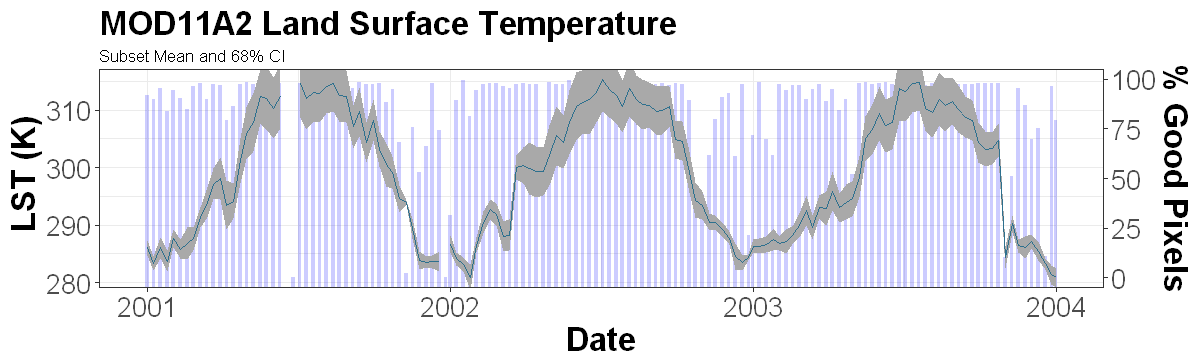

In [16]:
# find the 68% confidence intervals around the mean
y1 <- lststats$mean + lststats$sd 
y2 <- lststats$mean - lststats$sd

plot <- ggplot(lststats) +
  # Data quality
  geom_col(aes(y=scaleq(lststats$quality), x=date), fill= 'blue', alpha = 0.2) +
  scale_y_continuous(limits = c(meanMin, meanMax), oob = rescale_none, sec.axis = sec_axis(~((. - meanMin)/(meanMax - meanMin))*100, name = "% Good Pixels")) +

  # LST mean and sd
  geom_ribbon(aes(ymin=y2, ymax=y1, x=date), fill = 'darkgray') + # draw the shaded area for 68% CI
  geom_line(aes(y=mean, x=date), colour = '#2D708EFF') + # draw the line for the mean value  

  labs(title = 'MOD11A2 Land Surface Temperature', subtitle = 'Subset Mean and 68% CI') +
  ylab(' LST (K)') + # add a y-axis label
  xlab("Date") + # add a x-axis label
  theme_bw() + # set the plot theme
  theme(plot.title = element_text(lineheight=.8, face="bold", size=20), 
        axis.title.x = element_text(face="bold", size=20), 
        axis.title.y = element_text(face="bold", size=20), 
        axis.text.x = element_text(size=16), 
        axis.text.y = element_text(size=16)) # set optional theme elements

options(repr.plot.width = 10, repr.plot.height = 3)
plot